### SEATTLE Modelisation

Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

La première partie nous a permis de réaliser un nettoyage des fichiers et une courte analyse exploratoire.
Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires et non-linéaire afin de prédire les émissions de CO2 et les consommations d'énergie des bâtiments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("C:/Users/leila/etude_CO2_NRJ.csv",sep=',',low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574 entries, 0 to 1573
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           1574 non-null   int64  
 1   BuildingType            1574 non-null   object 
 2   PrimaryPropertyType     1574 non-null   object 
 3   PropertyName            1574 non-null   object 
 4   Address                 1574 non-null   object 
 5   State                   1574 non-null   object 
 6   ZipCode                 1561 non-null   float64
 7   Neighborhood            1574 non-null   object 
 8   Latitude                1574 non-null   float64
 9   Longitude               1574 non-null   float64
 10  LargestPropertyUseType  1564 non-null   object 
 11  NumberofBuildings       1574 non-null   float64
 12  NumberofFloors          1574 non-null   float64
 13  PropertyGFATotal        1574 non-null   float64
 14  ENERGYSTARScore         1041 non-null   

On va regrouper les données d'identification des bâtiments qui n'ont pas d'utilite pour la modelisation mais doivent rester utilisables.
On conserve ENERGYSTARScore et on spprime la colonne dans le dataset, dans un premier temps, pour tester si on peut obtenir une prediction correcte des emissions de CO2 ou de consommation d'energie sans cette information.    


In [3]:
id_features=['OSEBuildingID', 'PropertyName','Latitude','Longitude','Address', 'ZipCode','State']
data_ID=data[id_features]
energystar_score=data['ENERGYSTARScore']
d1=data.drop(id_features+['ENERGYSTARScore'],axis=1)

On va separer les variables numeriques des variables categorielles pour normaliser les numeriques et encoder les categorielles

In [4]:
d1_num=d1.select_dtypes(include=['int64','float64'])
d1_cat=d1.select_dtypes(exclude=['int64','float64'])
print(list(d1_num.columns))
d1_cat.nunique()
      

['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GFABuildingProp', 'GFAParkingProp', 'GFAPerBuilding', 'GFAPerFloor', 'AgeBuilding']


BuildingType               5
PrimaryPropertyType       22
Neighborhood              13
LargestPropertyUseType    56
UseTypeNumber              2
PrimaryType                8
dtype: int64

In [5]:
d1_cat['BuildingType'].value_counts()

NonResidential        1459
Nonresidential COS      81
Campus                  23
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [6]:
d1_cat=d1_cat.drop(['PrimaryPropertyType','LargestPropertyUseType','BuildingType'],axis=1)
d_reg=pd.concat([d1_cat, d1_num], axis=1)
d_reg.columns


Index(['Neighborhood', 'UseTypeNumber', 'PrimaryType', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'GFABuildingProp', 'GFAParkingProp',
       'GFAPerBuilding', 'GFAPerFloor', 'AgeBuilding'],
      dtype='object')

#### Variable categorielle  

Les variables categorielles vont etre codees suivant deux methodes :  
pour 'UseTypeNumber' par one_hot_encoder, ce qui signifie que l'on cree une colonne par valeur de variable et chaque nouvelle colonne a pour valeur 0 ou 1 correspondant a l'observation avait cette valeur de categorie ou non 

Pour 'Neighborhood' et 'PrimaryType' par TargetEncoder, qui remplace la cible par la probabilite  $𝑃_𝐵(𝐴)∗𝑃(𝐵) $ ou  $𝑃_𝐵(𝐴)$  est la probabilite de realisation de la cible sachant que l'on est restreint à la cible (dans notre cas c'est 1 car on n'a pas de valeurs manquantes) et  𝑃(𝐵)  est la probabilite de la cible. La TargetEncoder ne rajoute pas de dimension au dataset mais est sensible à la distribution de la cible (ce qui peut entrainer un overfitting).

Les variables numeriques n'etant ni dans la meme unite ni de meme ordre de grandeur nous devons les mettre a l'echelle pour que celles qui ont de grandes valeurs ne soient pas dominantes dans les algo de ML. La presence de outliers nous poussent a utiliser RobustScaler. Donc pour chaque variable nous allons remplacer la valeur $x$ par $\frac{x-mediane}{q_3-q_1}$  

In [7]:
from category_encoders.target_encoder import TargetEncoder

In [8]:
one_hot_users=pd.get_dummies(d_reg['UseTypeNumber'])
d_reg.drop(['UseTypeNumber'],axis=1, inplace=True)
d_reg=pd.concat([d_reg, one_hot_users], axis=1)


In [9]:
standard_features=list(d_reg.select_dtypes(include=['uint8']).columns)
standard_transformer = StandardScaler()

target_features =['Neighborhood', 'PrimaryType']
target_transformer = TargetEncoder()

num_features=['NumberofBuildings','NumberofFloors','PropertyGFATotal','GFABuildingProp','GFAPerFloor','AgeBuilding']
num_transformer=RobustScaler()

preprocessor=ColumnTransformer(transformers=[('stand',standard_transformer,standard_features),
                                             ('target',target_transformer,target_features),
                                               ('num',num_transformer, num_features)])

### Modelisation

Nous allons utiliser deux fonctions, l'une qui permet de rechercher les meilleurs parametres par validation croisee et l'autre qui stocke les resultats obtenus sur le training set dans un dataframe

In [10]:
def grid_cv(param,model):
    return   GridSearchCV(model,
                          param_grid=param,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error', n_jobs = -1)

In [11]:
def model_scores(pip,step):
    df_results=pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_nmae=-pip.named_steps[step].best_score_
    best_r2=np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params=pip.named_steps[step].best_params_
    training_time=round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results

Separation du data en jeu d'entrainement et jeu de test

In [12]:
from sklearn.model_selection import train_test_split

X=d_reg.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'],axis=1)
Y=d_reg[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1259 lignes,
Test: 315 lignes.



Pour avoir un ordre de grandeur sur la MAE 

In [13]:
from sklearn.dummy import DummyRegressor
 
dum_reg=DummyRegressor(strategy='mean')
dum_reg.fit(X, Y['TotalGHGEmissions'])
y_pred=dum_reg.predict(X)
y_t=np.array(Y['TotalGHGEmissions'])
diff=y_t-y_pred
mae=np.mean(abs(diff))
print('MAE :',mae)


MAE : 199.59742071366185


In [14]:
dum_reg.fit(X, Y['SiteEnergyUse(kBtu)'])
y_pred=dum_reg.predict(X)
y_t=np.array(Y['SiteEnergyUse(kBtu)'])
diff=y_t-y_pred
mae=np.mean(abs(diff))
print('MAE :',mae)


MAE : 8492603.065074433


#### Modele de base : regression lineaire

Le premier modele que l'on va utiliser est un modele lineaire. L'avantage du lineaire est qu'on obtient des solutions exactes.  
Le jeu de donnees et les variables a predire font qu'une approche lineaire ne peut donner des resultats interessants. Il est illusoire de pouvoir predire lineairement la consommation d'energie ou l'emission de CO2 des batiments ou parking.
Le modele lineaire nous servira de base de reference, si on ne trouve pas de modele ameliorant les scores de la regression cela voudra dire qu'il faudra revoir tout ce qui a ete fait pour le choix des features 

In [15]:
param_reg={'regressor__fit_intercept': [True, False],'regressor__normalize': [True, False]}
model=TransformedTargetRegressor(regressor=LinearRegression(),func=np.log,inverse_func=np.exp)
reg_grid_cv=Pipeline([('preprocessor',preprocessor),('grid_search_reg',grid_cv(param_reg,model))])
                                                   
co2_reg_model=reg_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
co2_reg_results=model_scores(co2_reg_model, 'grid_search_reg')

Meilleur score MAE : 186.602
Meilleur Score R2 : -8.22
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 10.5s


Comme on pouvait s'y attendre les resultats ne sont pas bons...

Text(0, 0.5, 'residus')

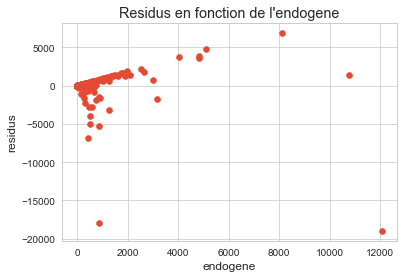

In [16]:
co2_reg_pred=co2_reg_model.predict(X_train)
y=np.array(Y_train['TotalGHGEmissions'])
residus=y-co2_reg_pred
plt.scatter(y,residus)
plt.title("Residus en fonction de l'endogene")
plt.xlabel('endogene')
plt.ylabel('residus')

La repartition des residus en fonction de l'endogene montre que la relation n'est pas lineaire

In [17]:
nrj_reg_model=reg_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
nrj_reg_results=model_scores(nrj_reg_model, 'grid_search_reg')

Meilleur score MAE : 8218688.288
Meilleur Score R2 : -15.68
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 2.38s


Comme prevu les scores sont mauvais sur le lineaire, il est donc illusoire de penser ameliorer cette situation en utilisant un ridge (reduction de l'amplitude des coefficients) ou un lasso (suppression des variables correlees par un coefficient a 0) ou Elasticnet qui est une combinaison de ridge et lasso. Les parametres de regularisations ne modifiant pas l'approche lineaire.  

### SVR  (Support  Vector Regression) a noyau

SVR,initialement proposé par Drucker et al., est une technique d'apprentissage supervisé, basée sur le concept des vecteurs de support de Vapnik. SVR vise à réduire l'erreur en déterminant l'hyperplan et en minimisant la plage entre les valeurs prédites et observées. 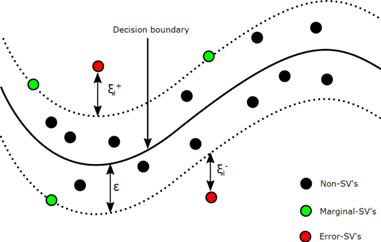



(https://ichi.pro/assets/images/max/724/1*bKI_PWOfdo9tTlMoGJIq_g.png)  

Les points verts sont les vecteurs supports des hyperplans
L'objectif est de maximiser la marge tout en minimisant l'erreur (points du mauvais cote de la frontiere de decision).
Le parametre $C$ regularise l'erreur par rapport a la marge.

Le noyau permet de plonger dans un espace de dimension superieure voir infinie, ce qui peut rendre les donnees lineairement separables. Les noyaux les plus utilises sont les noyaux lineaires et polynomiaux (pour des espaces de redescription de dimension finie) ou RBF (radial basis function) et sigmoid (pour des espaces de redescription de dimension infinie).



In [18]:
param_svr={'kernel' : ['poly', 'rbf', 'sigmoid'], #choix sur le noyau
             'C' : np.logspace(-2, 4, 6),
             'max_iter': [200,1000,3000,10000]}

svr_grid_cv=Pipeline([('preprocessor', preprocessor),('grid_search_svr',grid_cv(param_svr,svm.SVR()))])

co2_svr_model=svr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
co2_svr_results=model_scores(co2_svr_model, 'grid_search_svr')                           

Meilleur score MAE : 133.232
Meilleur Score R2 : 0.242
Meilleurs paramètres : {'C': 10000.0, 'kernel': 'rbf', 'max_iter': 10000}
Temps moyen d'entrainement : 84.22s


In [19]:
nrj_svr_model=svr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
nrj_svr_results=model_scores(nrj_svr_model, 'grid_search_svr')

Meilleur score MAE : 6052569.503
Meilleur Score R2 : 0.01
Meilleurs paramètres : {'C': 10000.0, 'kernel': 'poly', 'max_iter': 1000}
Temps moyen d'entrainement : 72.24s


On a trouve que pour le CO2 le meilleur kernel est RBF , on va donc tester les differents parametres pour ce noyau

In [20]:
param_svrk={'kernel':['rbf'],
             'gamma' : [0.005, 0.0075, 0.01],
             'C' : np.logspace(-2, 4, 6),
             'max_iter': [200,1000,3000,10000]}

svr_grid_cvk=Pipeline([('preprocessor', preprocessor),('grid_search_svrk',grid_cv(param_svrk,svm.SVR()))])
co2_svr_modelk=svr_grid_cvk.fit(X_train,Y_train['TotalGHGEmissions'])
co2_svr_resultsk=model_scores(co2_svr_modelk, 'grid_search_svrk')

Meilleur score MAE : 128.737
Meilleur Score R2 : 0.196
Meilleurs paramètres : {'C': 630.957344480193, 'gamma': 0.0075, 'kernel': 'rbf', 'max_iter': 1000}
Temps moyen d'entrainement : 156.64s


Un SVR a noyau n'est pas un modele qui convient

### Random Forest

Cet algorithme repose sur les arbres de decisions.
Parallelisationd'arbres de decisions independants traitant seulement une partie des donnees obtenue par un double tirage aleatoire :
- Tree bagging : tirage sur les observations
- Feature sampling : tirage sur les variables

*
**Algorithme RandomForest**  :

On tire au hasard dans la base d’apprentissage $B$ echantillons avec remise $z_i,i \in \{1,…,B\}$ (chaque echantillon ayant $n$ points).

Pour chaque echantillon $i$ on construit un arbre CART $G_i(x)$ selon un algorithme legerement modifie : a chaque fois qu’un nœud doit etre coupe (etape “split”) on tire au hasard une partie des attributs ($q$ parmi les $p$ attributs) et on choisit le meilleur decoupage dans ce sous-ensemble.  
Regression : agregation par la moyenne $G(x)= \frac{1}{B} \sum\limits_{i=1}^BG_i(x)$.  


Les parametres sont :
- n_estimators : nombre d'arbres dans la foret
- max_features : nombre max de features pour partionner un noeud
- min_samples_split : nombre min d'observations dans le noeud avant de le partitionner
- min_samples_leaf : nombre min d'observations dans une feuille
- boot_strap : methode de sampling (avec ou sans remplacement)

In [21]:
# on randomise la recherche pour un gain de temps
def rand_cv(param,model):
    return RandomizedSearchCV(model,
                          param_distributions=param,n_iter=20,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error', n_jobs = -1)

In [22]:
param_rfr={'max_features' : ['sqrt', 'auto'],
             'max_depth': [5, 10, 15, 50],
             'min_samples_split': [2, 5, 10],
             'bootstrap' : [True, False],
             'min_samples_leaf': [1,2,4],
             'n_estimators': [50, 200, 400, 500]}


rfr_grid_cv=Pipeline([('preprocessor', preprocessor),('grid_search_rfr', rand_cv(param_rfr,RandomForestRegressor()))]) 

co2_rfr_model=rfr_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
co2_rfr_results=model_scores(co2_rfr_model, 'grid_search_rfr')
co2_rfr_pred=co2_rfr_model.predict(X_test)


Meilleur score MAE : 125.475
Meilleur Score R2 : 0.542
Meilleurs paramètres : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Temps moyen d'entrainement : 2243.02s


In [23]:
nrj_rfr_model=rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
nrj_rfr_results=model_scores(nrj_rfr_model, 'grid_search_rfr')
nrj_rfr_pred=nrj_rfr_model.predict(X_test)

Meilleur score MAE : 4110964.121
Meilleur Score R2 : 0.663
Meilleurs paramètres : {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Temps moyen d'entrainement : 2145.66s


On obtient des resultats plus satisfaisants mais loin d'etre efficaces pour une prediction interessante

### XGBoost

Les algorithmes de Boosting se basent sur le meme principe que ceux de Bagging, mais pour le Boosting les algorithmes ne sont plus independants, au contraire ils sont en series pour que chaque apprenant faible soit entraine pour corriger les erreurs de l'apprenant faible precedent.  

Pour XGBoost, les apprenants faibles sont des arbres de decision qui sont elagues jusqu'a ce qu'ils soient suffisamment performants sinon ils sont supprimes.XGBoost ne conserve ainsi que les appenants faibles performants.  

L'aLgorithme travaille de maniere sequentielle ce qui lui permet de s'ameliorer par capitalisation par rapport aux executions precedentes. Il commence par construire un premier modele donnant la moyenne des observations puis il  calcule l'ecart entre la moyenne obtenue et la realite soit premier residu. Il essaye de predire a chaque etape les residus. Le deuxieme apprenant faible est entraine pour predire le premier residu.
Les predictions du deuxieme apprenant sont alors multipliees par un facteur inferieur a 1, parce que plusieurs petits pas sont plus precis que des grands pas quand on utilise la descente de gradient. L'objectif de ce parametre est d'augmenter la precision en s'ecartant petit a petit de la moyenne pour se rapprocher de la realite.
La creation des apprenants suit alors toujours le meme pattern :
- calcul des nouveaux residus
- entrainement du nouvel apprenant pour predire ces residus
- multiplication des predictions par un facteur inferieur a 1

Les parametres :
- learning rate : taux d'apprentissage qui reduit les ponderations des features pour eviter l'overfiiting
- gamma : reduction minimale de la pente pour effectuer une partition supplementaire
- max_depth : profondeux max de chaque arbre
- min_child_weight : nombre min d'echantillons dans un noeud pour etre partitionne
- n_estimators : nombre d'arbres


In [24]:
import xgboost as xgb

In [25]:
param_xgb={'xgb__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'xgb__gamma': [0.01,0.1, 0.25, 0.5, 1.0],
             'xgb__max_depth': [5,6, 10, 15],
             'xgb__min_child_weight' : [0.1,0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'xgb__n_estimators': [25, 50, 100, 500, 1000]}

xgb_grid_cv=Pipeline([('preprocessor', preprocessor),
                        ('grid_search_xgb',rand_cv(param_xgb,xgb.XGBRegressor(tree_method='hist')))])                          
                            

In [26]:
co2_xgb_model=xgb_grid_cv.fit(X_train, Y_train['TotalGHGEmissions'])
co2_xgb_results=model_scores(co2_xgb_model, 'grid_search_xgb')
co2_xgb_pred=co2_xgb_model.predict(X_test)


[12:01:46] WARNING: ..\src\learner.cc:541: 
Parameters: { xgb__gamma, xgb__learning_rate, xgb__max_depth, xgb__min_child_weight, xgb__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Meilleur score MAE : 128.308
Meilleur Score R2 : 0.447
Meilleurs paramètres : {'xgb__n_estimators': 500, 'xgb__min_child_weight': 3.0, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1}
Temps moyen d'entrainement : 1168.7s


In [27]:
nrj_xgb_model=xgb_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
nrj_xgb_results=model_scores(nrj_xgb_model, 'grid_search_xgb')
nrj_xgb_pred=nrj_xgb_model.predict(X_test)

[12:01:59] WARNING: ..\src\learner.cc:541: 
Parameters: { xgb__gamma, xgb__learning_rate, xgb__max_depth, xgb__min_child_weight, xgb__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Meilleur score MAE : 4230479.12
Meilleur Score R2 : 0.655
Meilleurs paramètres : {'xgb__n_estimators': 50, 'xgb__min_child_weight': 10.0, 'xgb__max_depth': 6, 'xgb__learning_rate': 0, 'xgb__gamma': 0.25}
Temps moyen d'entrainement : 1183.29s


Maintenant que l'on a une idee des parametres, on peut voir si la situation est ameliorable

In [28]:
param_xgb={'xgb__learning_rate' : [0.001, 0.002],
             'xgb__gamma': [0.05, 0.1, 0.2],
             'xgb__max_depth': [6],
             'xgb__min_child_weight' : [0.5, 1., 1.5],
             'xgb__n_estimators': [25, 50, 100]}

xgb_grid_cva=Pipeline([('preprocessor', preprocessor),
                        ('grid_search_xgba',grid_cv(param_xgb,xgb.XGBRegressor(tree_method='hist')))]) 

In [29]:
co2_xgb_modela=xgb_grid_cva.fit(X_train, Y_train['TotalGHGEmissions'])
co2_xgb_resultsa=model_scores(co2_xgb_modela, 'grid_search_xgba')

[12:02:32] WARNING: ..\src\learner.cc:541: 
Parameters: { xgb__gamma, xgb__learning_rate, xgb__max_depth, xgb__min_child_weight, xgb__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Meilleur score MAE : 128.308
Meilleur Score R2 : 0.447
Meilleurs paramètres : {'xgb__gamma': 0.05, 'xgb__learning_rate': 0.001, 'xgb__max_depth': 6, 'xgb__min_child_weight': 0.5, 'xgb__n_estimators': 25}
Temps moyen d'entrainement : 1181.42s


Le random search est efficace et plus rapide !

Des resultats obtenus, on hesite entre RandomForest et XGBoost quelque soit la variable. On va regarder cela d'un peu plus pres.

In [30]:
# utilisation d'une fonction cree par johaupt pour retrouver le noms des features
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    feature_names : list of strings
        Names of the features produced by transform.
        
    Code from :
        https://johaupt.github.io/
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        feature_names.extend(get_names(trans))
    
    return feature_names

### Selection des modeles

Le lineaire quelque soit la dimension dans laquelle on se place ne parait pas etre judicieux. Pour tous les modeles le $R^2$ n'est pas bon donc les predictions vont etre assez eloignees

 de la realite  

**Pour l'emission de CO2**

In [31]:
metrics=['mean_fit_time','mean_score_time','mean_test_neg_mean_absolute_error','mean_train_neg_mean_absolute_error']
co2_compare_metrics=pd.concat([pd.DataFrame(co2_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(co2_xgb_results[metrics].mean(),columns=['XGBoost']),
           pd.DataFrame(co2_svr_results[metrics].mean(),columns=['SVR']),
           pd.DataFrame(co2_reg_results[metrics].mean(),columns=['LinearRegression'])], axis=1)
co2_final_metrics_compare=pd.DataFrame(columns=metrics,index=['RandomForest','XGBoost','SVR','LinearRegression'])
                                           
                                            
for m in metrics:
    co2_final_metrics_compare[m]=co2_compare_metrics.loc[m]

co2_final_metrics_compare



,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
RandomForest,1.781586,0.045976,-137.038730,-79.239004
XGBoost,0.928273,0.004717,-128.307556,-9.886099
SVR,0.066891,0.007860,-6470.551948,-6487.920503
LinearRegression,0.008339,0.000503,-828.040146,-551.031163


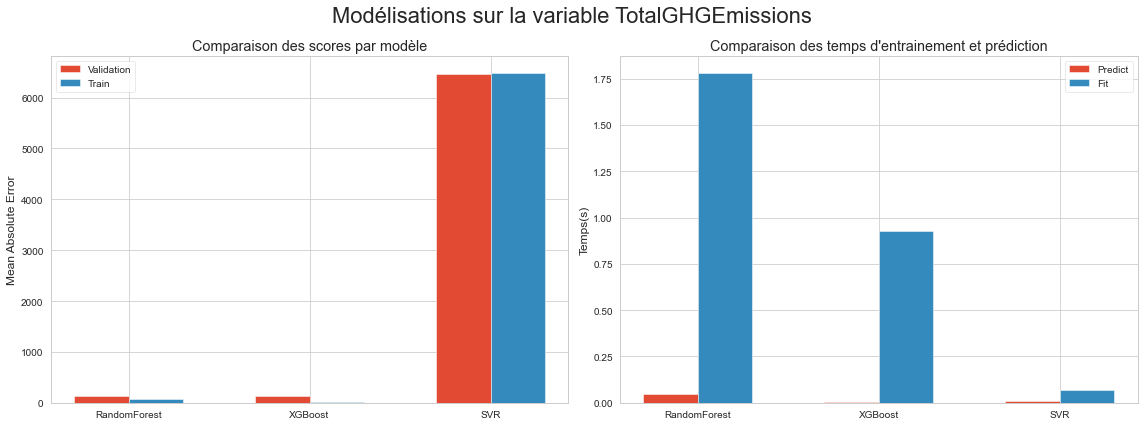

In [32]:
#on supprime LinearRegression qui n'a pas d'interet
co2_final_metrics_compare=co2_final_metrics_compare[co2_final_metrics_compare.index !='LinearRegression']
x=np.arange(len(co2_final_metrics_compare.index))
width=0.30

fig, ax =plt.subplots(1,2,figsize=(16,6), sharey=False, sharex=False)

score1=ax[0].bar(x-width/2,-1*co2_final_metrics_compare['mean_test_neg_mean_absolute_error'],width,label='Validation')
score2=ax[0].bar(x+width/2,-1*co2_final_metrics_compare['mean_train_neg_mean_absolute_error'],width,label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(co2_final_metrics_compare.index)
ax[0].legend()


times1=ax[1].bar(x-width/2,co2_final_metrics_compare['mean_score_time'],width,label='Predict')
times2=ax[1].bar(x+width/2,co2_final_metrics_compare['mean_fit_time'],width,label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(co2_final_metrics_compare.index)
ax[1].legend()


plt.suptitle("Modélisations sur la variable TotalGHGEmissions", fontsize=22)
fig.tight_layout()

plt.show()

Regardons ce qui se passe sur le jeu de test

In [33]:
# calcul des scores sur le jeu de test
def metrics_model(y_t, y_pred):
    y_t, y_pred=np.array(y_t), np.array(y_pred)
    diff=y_t-y_pred
    mae=np.mean(abs(diff))
    r2=1-(sum(diff**2)/sum((y_t-np.mean(y_t))**2))
    dict_metrics={"Métrique":["MAE", "R²"], "Résultats":[mae, r2]}
    df_metrics=pd.DataFrame(dict_metrics)
    return df_metrics

# representation des valeurs predites par rapport aux valeurs reelles
def plot_pred_true(y_t, y_pred, color=None):
    X_plot=[y_t.min(), y_t.max()]
    fig=plt.figure(figsize=(8,4))
    plt.scatter(y_t, y_pred, color=color, alpha=.6)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs reelles")
    plt.ylabel("Valeurs predites")
    plt.title("Valeurs predites VS valeurs reelles" ,fontsize=12)
    plt.show()



In [34]:
co2_rfr_metrics=metrics_model(Y_test['TotalGHGEmissions'],co2_rfr_pred)
co2_rfr_metrics

,Métrique,Résultats
0,MAE,132.328369
1,R²,0.295063


Les resultats sont fortement degrades sur le jeu de test

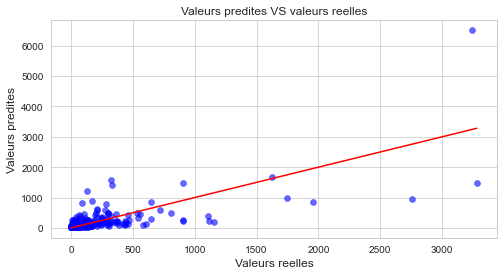

In [35]:
plot_pred_true(Y_test['TotalGHGEmissions'],co2_rfr_pred,'b')

Text(0, 0.5, 'MAE')

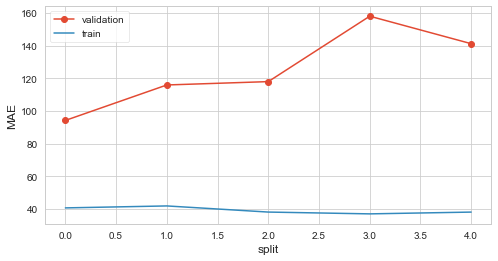

In [36]:
co2_test_rfr_results=-co2_rfr_results[['split'+str(k)+'_test_neg_mean_absolute_error' for k in range(5)]]\
                    [co2_rfr_results['rank_test_neg_mean_absolute_error']==1].values
co2_train_rfr_results=-co2_rfr_results[['split'+str(k)+'_train_neg_mean_absolute_error' for k in range(5)]]\
                    [co2_rfr_results['rank_test_neg_mean_absolute_error']==1].values


plt.figure(figsize=(8,4))
plt.plot(range(0,5), co2_test_rfr_results.reshape(-1),marker='o')
plt.plot(range(0,5), co2_train_rfr_results.reshape(-1))
plt.legend(['validation','train'])
plt.xlabel('split')
plt.ylabel('MAE')

On ne constate pas d'overfitting, les moyennes dans le jeu de train sont entre 90 et 100. Dans le jeu de test il y a un probleme au 4 eme split.

Regardons l'importance des features

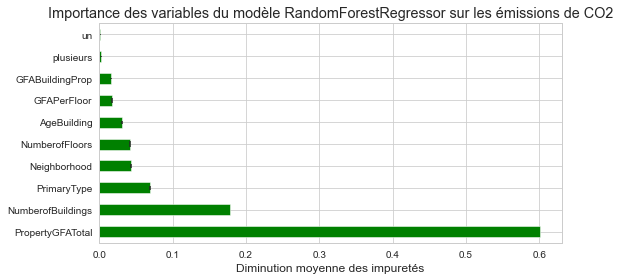

In [37]:
feature_importance=co2_rfr_model.named_steps['grid_search_rfr'].best_estimator_.feature_importances_ 
features_names=get_feature_names(co2_rfr_model.named_steps['preprocessor'])


std=np.std([tree.feature_importances_ for tree in co2_rfr_model.named_steps['grid_search_rfr'].best_estimator_],
           axis=0)
df_feature_importance=pd.Series(feature_importance, index=features_names).sort_values(ascending=False)

fig, ax =plt.subplots(figsize=(8,4))
df_feature_importance.plot.barh(yerr=std, ax=ax,color='g')
ax.set_title("Importance des variables du modèle RandomForestRegressor sur les émissions de CO2")
ax.set_xlabel("Diminution moyenne des impuretés")
fig.tight_layout()

La surface de la propriete est nettement dominante dans le modele, suivie par le nombre de batiments. On se rend compte qu'il manque une donnee indiquant le nombre d'heures d'utilisation du batiment par jour.

In [38]:
co2_xgb_metrics=metrics_model(Y_test['TotalGHGEmissions'],co2_xgb_pred)
co2_xgb_metrics

,Métrique,Résultats
0,MAE,136.770200
1,R²,0.304233


la encore les resultats sont tres mauvais sur le jeu de test

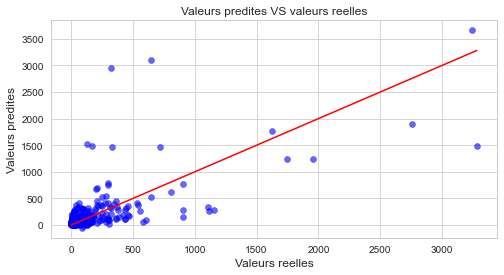

In [39]:
plot_pred_true(Y_test['TotalGHGEmissions'],co2_xgb_pred,'b')


Conclusion : le modele le moins mauvais pour l'emission de CO2 est difficile à choisir entre RandomForest et XGBoost sur les résultats des prédictions. XGBoost l'emporte pour la rapidité. Il ne suffira pas pour donner des previsions corrects. Le faible nombre de donnees est une des raisons de mauvaise modelisation, une autre est, sans aucun doute, que je n'ai pas su trouver un bon modele.

**Pour la consommation d'energie**

In [40]:
metrics=['mean_fit_time','mean_score_time','mean_test_neg_mean_absolute_error','mean_train_neg_mean_absolute_error']
nrj_compare_metrics=pd.concat([pd.DataFrame(nrj_rfr_results[metrics].mean(), columns=['RandomForest']),
           pd.DataFrame(nrj_xgb_results[metrics].mean(),columns=['XGBoost']),
           pd.DataFrame(nrj_svr_results[metrics].mean(),columns=['SVR']),
           pd.DataFrame(nrj_reg_results[metrics].mean(),columns=['LinearRegression'])], axis=1)
nrj_final_metrics_compare=pd.DataFrame(columns=metrics, 
                                     index=['RandomForest','XGBoost','SVR','LinearRegression'])
                                           
                                            
for m in metrics:
    nrj_final_metrics_compare[m]=nrj_compare_metrics.loc[m]

nrj_final_metrics_compare


,mean_fit_time,mean_score_time,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error
RandomForest,1.704255,0.055458,-4.395830e+06,-2.882221e+06
XGBoost,0.939864,0.004746,-4.230479e+06,-3.066490e+05
SVR,0.057376,0.008055,-6.601422e+06,-6.599022e+06
LinearRegression,0.001889,0.000781,-1.773942e+10,-6.579259e+09


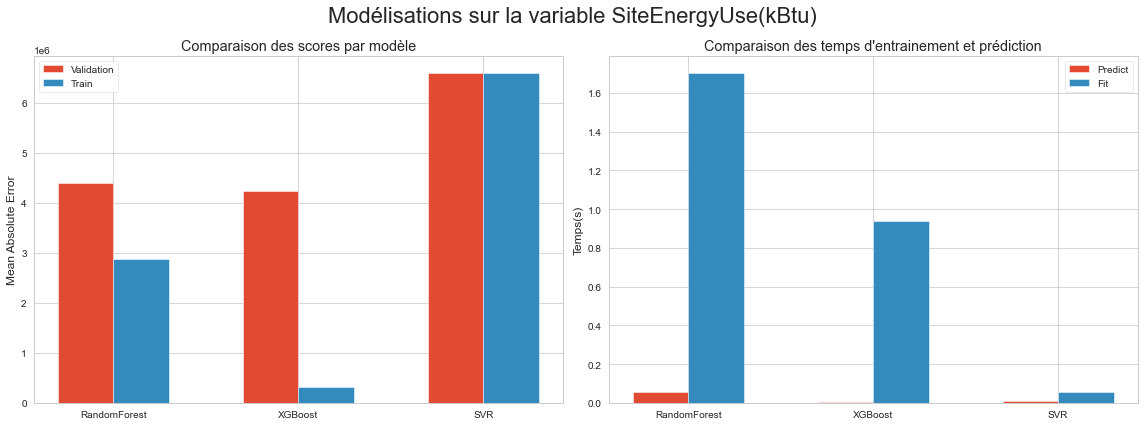

In [41]:
#on supprime LinearRegression qui n'a pas d'interet
nrj_final_metrics_compare=nrj_final_metrics_compare[nrj_final_metrics_compare.index !='LinearRegression']
x=np.arange(len(nrj_final_metrics_compare.index))
width=0.30

fig, ax =plt.subplots(1,2,figsize=(16,6), sharey=False, sharex=False)

score1=ax[0].bar(x-width/2,-1*nrj_final_metrics_compare['mean_test_neg_mean_absolute_error'],width,label='Validation')
score2=ax[0].bar(x+width/2,-1*nrj_final_metrics_compare['mean_train_neg_mean_absolute_error'],width,label='Train')
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(nrj_final_metrics_compare.index)
ax[0].legend()


times1=ax[1].bar(x-width/2,nrj_final_metrics_compare['mean_score_time'],width,label='Predict')
times2=ax[1].bar(x+width/2,nrj_final_metrics_compare['mean_fit_time'],width,label='Fit')
ax[1].set_ylabel('Temps(s)')
ax[1].set_title("Comparaison des temps d'entrainement et prédiction")
ax[1].set_xticks(x)
ax[1].set_xticklabels(nrj_final_metrics_compare.index)
ax[1].legend()


plt.suptitle("Modélisations sur la variable SiteEnergyUse(kBtu)", fontsize=22)
fig.tight_layout()

plt.show()

In [42]:
nrj_rfr_metrics=metrics_model(Y_test['SiteEnergyUse(kBtu)'],nrj_rfr_pred)
nrj_rfr_metrics

,Métrique,Résultats
0,MAE,5.271935e+06
1,R²,2.981361e-01


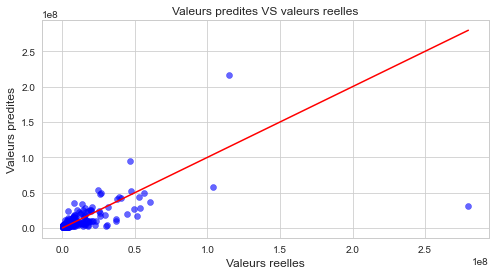

In [43]:
plot_pred_true(Y_test['SiteEnergyUse(kBtu)'],nrj_rfr_pred,'b')

In [44]:
nrj_xgb_metrics=metrics_model(Y_test['SiteEnergyUse(kBtu)'],nrj_xgb_pred)
nrj_xgb_metrics

,Métrique,Résultats
0,MAE,5.099969e+06
1,R²,3.846348e-01


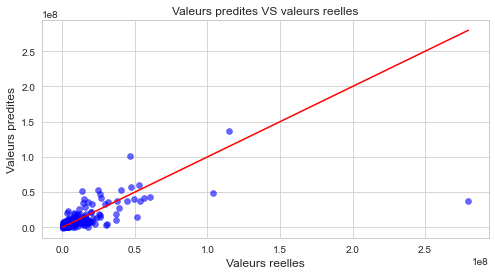

In [45]:
plot_pred_true(Y_test['SiteEnergyUse(kBtu)'],nrj_xgb_pred,'b')

Conclusion : Difficile de départager RandomForest de XGBoost. On peut considerer que XGBoost est legerement 
moins mauvais que RandomForest et plus rapide. Il faut bien aussi faire honneur a la Rolls des algo de ML !

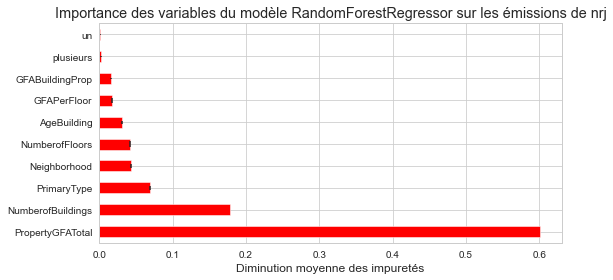

In [46]:
feature_importance=nrj_rfr_model.named_steps['grid_search_rfr'].best_estimator_.feature_importances_ 
features_names=get_feature_names(nrj_rfr_model.named_steps['preprocessor'])


std=np.std([tree.feature_importances_ for tree in nrj_rfr_model.named_steps['grid_search_rfr'].best_estimator_],
           axis=0)
df_feature_importance=pd.Series(feature_importance, index=features_names).sort_values(ascending=False)

fig, ax =plt.subplots(figsize=(8,4))
df_feature_importance.plot.barh(yerr=std, ax=ax,color='red')
ax.set_title("Importance des variables du modèle RandomForestRegressor sur les émissions de nrj")
ax.set_xlabel("Diminution moyenne des impuretés")
fig.tight_layout()

### Impact de Energy Star


La cote ENERGY STAR® de l’EPA est un outil d’analyse comparative externe qui permet d'évaluer le rendement énergétique des bâtiments commerciaux. La cote ENERGY STAR, représentée par une valeur dans un échelle simple de 1 à 100 exprime le rendement en fonction de percentiles. 
Les principaux objectifs de la cote ENERGY STAR : 
- Évaluer le rendement énergétique d'un bâtiment dans son ensemble.
- Refléter les données de la consommation d'énergie réellement mesurée.
- Prendre en considération de façon équitable les différentes sources d'énergie.
- Normaliser en fonction des activités d'un bâtiment.
- Offrir une analyse comparative à un groupe de bâtiments semblables.

La cote est calculee par une regression lineaire dont les variables explicatives sont les caracteristiques du batiment. Par rapport aux donnees que nous avons, Energy Star dispose de la donnee concernant comment fonctionne le batiment. Cette donnee nous manque dans notre modelisation : un hopital peut avoir la meme surface qu'un grand bureau mais l'hopital fonctionne 24h/24 alors que le bureau aura un fonctionnement eventuel de 12h/24. La consommation d'energie ou l'emission de CO2 doit donc tenir compte du comment le batiment fonctionne. Ceci est une des raisons pour lesquelles nos modelisation ne sont pas brillantes.

La question est : la connaissance de la cote d'Energy Star permet-elle une meilleure approximation des emissions de CO2 ou de consommation d'energie ?

In [47]:
#rajout de la colonne Energystar aux donnees
X['EnergyStar']=energystar_score

#il ne faut garder que les donnees renseignees sur EnergyStar
XES=X[X['EnergyStar'].notna()].copy()
YES=Y[Y.index.isin(list(XES.index))].copy()

XES.shape

(1041, 13)

moyenne = 63.10614793467819, mediane = 69.5


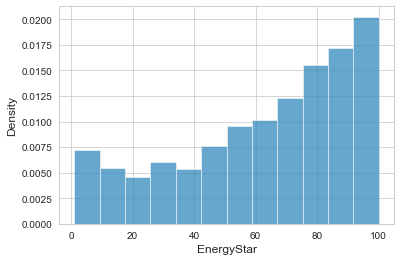

In [48]:
sns.histplot(data=XES,x='EnergyStar',stat="density")
print('moyenne = {}, mediane = {}'.format(XES['EnergyStar'].mean(),XES['EnergyStar'].median()))

EnergyStar ne suit pas une loi normale. La majorite des batiments a un score superieur a 69.

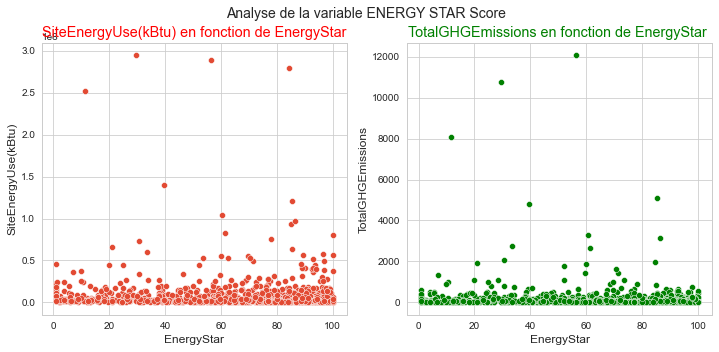

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12,5))
sns.scatterplot(data=pd.concat([XES,YES], axis=1), x='EnergyStar', y='SiteEnergyUse(kBtu)',ax=axes[0])
axes[0].set_title("SiteEnergyUse(kBtu) en fonction de EnergyStar", color='r')
sns.scatterplot(data=pd.concat([X,Y], axis=1), x='EnergyStar',y='TotalGHGEmissions',ax=axes[1],color='g')
axes[1].set_title("TotalGHGEmissions en fonction de EnergyStar ", color='g')
plt.suptitle("Analyse de la variable ENERGY STAR Score",fontsize=14)
plt.show()

In [50]:
print("Correlation d'EnergyStar avec SEU :{}, avec GHG : {}".format(XES['EnergyStar'].corr(Y['SiteEnergyUse(kBtu)']),
                                                                        XES['EnergyStar'].corr(Y['TotalGHGEmissions'])))

Correlation d'EnergyStar avec SEU :-0.03639589990380575, avec GHG : -0.0785017223331698


On a donc une faible correlation entre nos variables et EnergyStar.  

Regardons l'apport d'EnergyStar sur nos modeles et nos previsions

In [51]:
XES_train,XES_test, YES_train,YES_test = train_test_split(XES,YES,test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(XES_train.shape[0],XES_test.shape[0]))

Entrainement: 832 lignes,
Test: 209 lignes.



In [52]:
num_featuresES=num_features+['EnergyStar']
prepocessorES=ColumnTransformer(transformers=[('stand', standard_transformer, standard_features),
                                              ('target',target_transformer,target_features),
                                               ('num', num_transformer, num_featuresES)])


In [53]:
# on teste RandomForest pour CO2

rfr_grid_cvES=Pipeline([('preprocessorES', prepocessorES),
                        ('grid_search_rfrES', rand_cv(param_rfr,RandomForestRegressor()))]) 

co2_rfr_modelES=rfr_grid_cvES.fit(XES_train, YES_train['TotalGHGEmissions'])
co2_rfr_resultsES=model_scores(co2_rfr_modelES, 'grid_search_rfrES')


Meilleur score MAE : 127.342
Meilleur Score R2 : 0.366
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Temps moyen d'entrainement : 1872.3s


In [54]:
co2_pred_star=co2_rfr_modelES.predict(XES_test)
#Calcul des métriques pour les émissions de CO2
co2metricsES=metrics_model(YES_test['TotalGHGEmissions'],co2_pred_star)
co2metrics=co2_rfr_metrics.rename(columns={"Résultats" : "Sans EnergyStar"})
co2metrics['Avec EnergyStar']=co2metricsES['Résultats']
co2metrics

,Métrique,Sans EnergyStar,Avec EnergyStar
0,MAE,132.328369,106.215085
1,R²,0.295063,0.801980


On constate donc une tres nette amelioration en utilisant EnergyStar mais on a que 80 % de la variance expliquee

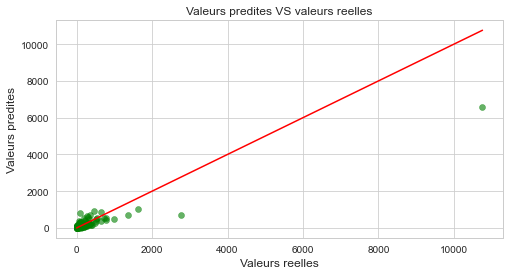

In [55]:
plot_pred_true(YES_test['TotalGHGEmissions'],co2_pred_star, color="g")

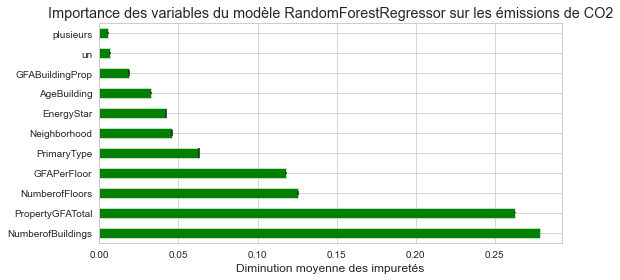

In [56]:
feature_importance2=co2_rfr_modelES.named_steps['grid_search_rfrES'].best_estimator_.feature_importances_ 
features_names2=get_feature_names(co2_rfr_modelES.named_steps['preprocessorES'])


std=np.std([tree.feature_importances_ for tree in co2_rfr_modelES.named_steps['grid_search_rfrES'].best_estimator_],
           axis=0)
df_feature_importance2=pd.Series(feature_importance2, index=features_names2).sort_values(ascending=False)

fig, ax =plt.subplots(figsize=(8,4))
df_feature_importance2.plot.barh(yerr=std, ax=ax,color='g')
ax.set_title("Importance des variables du modèle RandomForestRegressor sur les émissions de CO2")
ax.set_xlabel("Diminution moyenne des impuretés")
fig.tight_layout()

On peut regarder si le modele XGboost est plus performant que RandomForest avec EnergyStar

In [57]:
xgb_grid_cvES=Pipeline([('preprocessor',preprocessor),('grid_search_xgbES',rand_cv(param_xgb,
                                                                                   xgb.XGBRegressor(tree_method='hist')))]) 

co2_xgb_modelES=rfr_grid_cvES.fit(XES_train, YES_train['TotalGHGEmissions'])
co2_xgb_resultsES=model_scores(co2_xgb_modelES, 'grid_search_rfrES')
co2_pred_xgbstar=co2_xgb_modelES.predict(XES_test)
#Calcul des métriques pour les émissions de CO2
co2metricsxgbES=metrics_model(YES_test['TotalGHGEmissions'],co2_pred_xgbstar)
co2metricsxgb=co2_xgb_metrics.rename(columns={"Résultats" : "Sans EnergyStar"})
co2metricsxgb['Avec EnergyStar']=co2metricsxgbES['Résultats']
co2metricsxgb

Meilleur score MAE : 126.855
Meilleur Score R2 : 0.367
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
Temps moyen d'entrainement : 2152.09s


,Métrique,Sans EnergyStar,Avec EnergyStar
0,MAE,136.770200,106.568861
1,R²,0.304233,0.797235


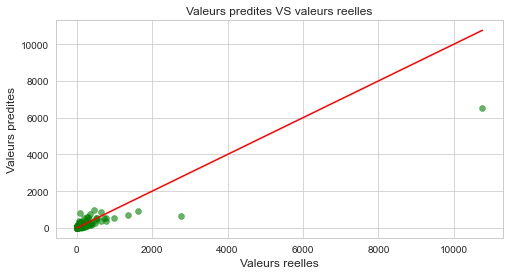

In [58]:
plot_pred_true(YES_test['TotalGHGEmissions'],co2_pred_xgbstar,color="g")

Pour l'emission de CO2, EnergyStar est un plus incontestable dans la prediction et le meilleur modele est RandomForest a epsilon pres  

Regardons maintenant pour la consommation d'energie, pour les deux modeles RandomForest et XGBoost

In [59]:
# pour RandomForest
print('Pour RandomForest on obtient :\n')
nrj_rfr_modelES=rfr_grid_cvES.fit(XES_train, YES_train['SiteEnergyUse(kBtu)'])
nrj_rfr_resultsES=model_scores(nrj_rfr_modelES, 'grid_search_rfrES')

nrj_pred_rfrstar=nrj_rfr_modelES.predict(XES_test)

nrjmetricsES=metrics_model(YES_test['SiteEnergyUse(kBtu)'],nrj_pred_rfrstar)
nrjmetrics=nrj_rfr_metrics.rename(columns={"Résultats" : "Sans EnergyStar"})
nrjmetrics['Avec EnergyStar']=nrjmetricsES['Résultats']
print(nrjmetrics)

#pour XGBoost
print('\n Pour XGBoost on obtient : \n')
nrj_xgb_modelES=rfr_grid_cvES.fit(XES_train, YES_train['SiteEnergyUse(kBtu)'])
nrj_xgb_resultsES=model_scores(nrj_xgb_modelES, 'grid_search_rfrES')
nrj_pred_xgbstar=nrj_xgb_modelES.predict(XES_test)

nrjmetricsxgbES=metrics_model(YES_test['SiteEnergyUse(kBtu)'],nrj_pred_xgbstar)
nrjmetricsxgb=nrj_xgb_metrics.rename(columns={"Résultats" : "Sans EnergyStar"})
nrjmetricsxgb['Avec EnergyStar']=nrjmetricsxgbES['Résultats']
nrjmetricsxgb

Pour RandomForest on obtient :

Meilleur score MAE : 4090030.302
Meilleur Score R2 : 0.583
Meilleurs paramètres : {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}
Temps moyen d'entrainement : 1826.02s
  Métrique  Sans EnergyStar  Avec EnergyStar
0      MAE     5.271935e+06     3.121759e+06
1       R²     2.981361e-01     8.680004e-01

 Pour XGBoost on obtient : 

Meilleur score MAE : 4128766.966
Meilleur Score R2 : 0.579
Meilleurs paramètres : {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
Temps moyen d'entrainement : 3610.42s


,Métrique,Sans EnergyStar,Avec EnergyStar
0,MAE,5.099969e+06,3.758130e+06
1,R²,3.846348e-01,7.012776e-01


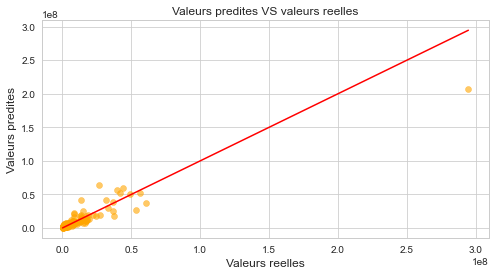

In [60]:
plot_pred_true(YES_test['SiteEnergyUse(kBtu)'],nrj_pred_rfrstar,color='orange')

On a encore une nette amelioration et le modele RandomForest est légèrement plus performant.

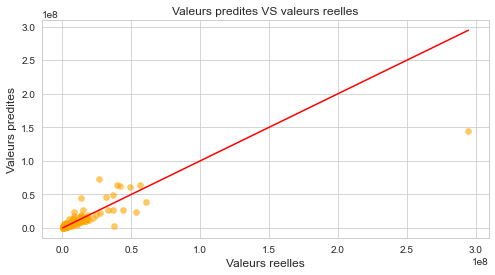

In [61]:
plot_pred_true(YES_test['SiteEnergyUse(kBtu)'],nrj_pred_xgbstar,color='orange')

Les conclusions que l'on a de cette etude sont :
- le faible nombre de donnees ne permet pas reellement d'obtenir une modelisation generalisable
- en l'etat, la donnee EnergyStar ameliore nettement les resultats mais laisse une marge d'erreurs importante
- il serait souhaitable de pouvoir inclure des donnees concernant l'activite humaine dans les bâtiments

